In [373]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as dt

In [380]:
class Utilities():

    def sigmoid(self, x):

        # compute sigmoid function #
        # returns 1D numpy array of values #

        return 1 / (1 + np.exp(-x))


    def batch_creator(batch_size, data):

        # creates a list of batches containing unique random indices from dataset #
        # returns list of batches #

        batches = []
        indices = np.arange(data[0].shape[0])
        np.random.shuffle(indices)
        for i in range(batch_size, indices.shape[0], batch_size):
            batches.append(indices[i - batch_size:i])
        return batches
    

    def round_preds(batch_size, y_bars):

        # rounds predictions to either 0 or 1 #
        # returns a 1D numpy array of binary values #

        rounded_y_bars = np.zeros((batch_size))
        for i, y_bar in enumerate(y_bars):
            if y_bar >= 0.5:
                rounded_y_bars[i] = 1
        return rounded_y_bars
    

    def BCE_loss(self, y_bars, ys):

        # calculates binary cross entropy loss #
        # returns mean loss of all preds #
        
        losses = -(ys * np.log(y_bars) + (1 - ys) * np.log(1 - y_bars))
        return np.mean(losses)
    

    def gradient_descent(self, lr, gradients, weights):
        
        # updates all weights using gradient descent #
        # returns updated weights #
        
        g_names = list(gradients.keys())
        w_names = list(weights.keys())
        for i in range(len(g_names)):
            weights[w_names[i]] -= lr * gradients[g_names[i]]
        return weights
    

    def train_test_val_split(split_vals, data):

        # splits data into training, testing and validation sets #
        # returns split data #

        np.random.seed(42)
        indices = np.arange(data[0].shape[0])
        np.random.shuffle(indices)
        train_data = (  data[0][indices[0:int(np.floor(indices.shape[0] * split_vals[0]))]],
                        data[1][indices[0:int(np.floor(indices.shape[0] * split_vals[0]))]]
                    )
        test_data = (   data[0][indices[int(np.ceil(indices.shape[0] * split_vals[0])): 
                                        int(np.floor(indices.shape[0] * (split_vals[0] + split_vals[1])))]],
                        data[1][indices[int(np.ceil(indices.shape[0] * split_vals[0])): 
                                        int(np.floor(indices.shape[0] * (split_vals[0] + split_vals[1])))]]
                    )
        val_data = (    data[0][indices[int(np.ceil(indices.shape[0] * (split_vals[0] + split_vals[1]))):]],
                        data[1][indices[int(np.ceil(indices.shape[0] * (split_vals[0] + split_vals[1]))):]]
                    )
        return (train_data, test_data, val_data)
        

    def normaliser(split_data):

        # normalises data #
        # returns normalised data #

        normalised_data = ((np.zeros(split_data[0][0].shape), split_data[0][1]),
                             (np.zeros(split_data[1][0].shape), split_data[1][1]),
                             (np.zeros(split_data[2][0].shape), split_data[2][1])
                            )

        for j in range(split_data[0][0].shape[1]):
            data_max = max(split_data[0][0][:, j])
            data_min = min(split_data[0][0][:, j])
            for i in range(len(split_data)):
                normalised_data[i][0][:, j] = (split_data[i][0][:, j] - data_min) / (data_max - data_min)
        
        return normalised_data
    

    def accuracy(ys, y_bars):

        # calculates accuracy of NN #
        # returns a scaler score between 0 and 1 #

        return np.count_nonzero(ys - y_bars==0) / ys.shape[0]

In [381]:
class NN(Utilities):
    def __init__(self, input_layer_size, layer2_size, output_layer_size, batch_size, lr):
        super(NN, self).__init__()
        self.input_layer_size = input_layer_size
        self.batch_size = batch_size
        self.lr = lr
        self.layer2_size = layer2_size
        self.output_layer_size = output_layer_size
        self.input_layer = np.random.uniform(-1, 1, 
                                            (self.layer2_size, 
                                            self.input_layer_size)
                                            )   
        self.layer2 = np.random.uniform(-1, 1, 
                                        (self.output_layer_size, 
                                        self.layer2_size)
                                        )
        self.output_layer = np.random.uniform(-1, 1, 
                                            (1, 
                                            self.output_layer_size)
                                            )


    def forward_prop(self, batch):

        # forward propagation through network #
        # returns a memory dict of all useful information #

        forward_mem = { 'h_1'   :   np.zeros(self.input_layer_size),
                        'h_2'   :   np.zeros(self.layer2_size),
                        'h_3'   :   np.zeros(self.output_layer_size),
                        'h_4'   :   0,
                        'a_1'   :   np.zeros(self.layer2_size),
                        'a_2'   :   np.zeros(self.output_layer_size),
                        'y_bar' :   0,
                        'y'     :   0
                    }

        y_bars = np.zeros((batch[0].shape[0]))
                    
        for i in range(batch[0].shape[0]):
            x = batch[0][i, :]
            forward_mem['h_1'] += (x / batch[0].shape[0])
            # input layer
            x = np.dot(self.input_layer, x)
            forward_mem['h_2'] += (x / batch[0].shape[0])
            # activation layer 1
            x = np.tanh(x)
            forward_mem['a_1'] += (x / batch[0].shape[0])
            # second layer
            x = np.dot(self.layer2, x)
            forward_mem['h_3'] += (x / batch[0].shape[0])
            # activation layer 2
            x = np.tanh(x)
            forward_mem['a_2'] += (x / batch[0].shape[0])
            # output layer
            x = np.dot(self.output_layer, x)
            forward_mem['h_4'] += (x / batch[0].shape[0])
            # perform sigmoid
            y_bar = self.sigmoid(x)
            y_bars[i] = y_bar
            forward_mem['y_bar'] += (y_bar / batch[0].shape[0])
            forward_mem['y'] += (batch[1][i] / batch[0].shape[0])

        forward_mem['y_bars'] = y_bars
        # calculate loss
        forward_mem['loss'] = self.BCE_loss(y_bars, batch[1])

        return forward_mem


    def backward_prop(self, forward_mem):

        # backward propagation through network #

        gradients = {}
        
        # first layer backprop
        dL_dy_bar = (forward_mem['y_bar'] - forward_mem['y']) / (forward_mem['y_bar'] - np.square(forward_mem['y_bar']))
        dy_bar_dh_4 = np.exp(-forward_mem['h_4']) / np.square(1 + np.exp(-forward_mem['h_4']))
        dh_4_dw_3 = forward_mem['a_2']
        dL_dw_3 = dL_dy_bar * dy_bar_dh_4 * dh_4_dw_3
        gradients['dL_dw_3'] = dL_dw_3

        # second layer backprop
        dh_4_da_2 = self.output_layer
        dL_da_2 = dL_dy_bar * dy_bar_dh_4 * dh_4_da_2
        da_2_dh_3 = 4 / np.square((np.exp(-forward_mem['h_3']) + np.exp(forward_mem['h_3'])))
        dh_3_dw_2 = forward_mem['a_1']
        dL_dw_2 = np.dot((dL_da_2 * da_2_dh_3).T, np.reshape(dh_3_dw_2, (1, dh_3_dw_2.shape[0])))
        gradients['dL_dw_2'] = dL_dw_2

        # third layer backprop
        dh_3_da_1 = self.layer2
        dL_da_1 = np.dot((dL_da_2 * da_2_dh_3), dh_3_da_1)
        da_1_dh_2 = 4 / np.square((np.exp(-forward_mem['h_2']) + np.exp(forward_mem['h_2'])))
        dh_2_dw_1 = forward_mem['h_1']
        dL_dw_1 = np.dot((dL_da_1 * da_1_dh_2).T, np.reshape(dh_2_dw_1, (1, dh_2_dw_1.shape[0])))
        gradients['dL_dw_1'] = dL_dw_1

        weights = {
                    'w_3'    :   self.output_layer,
                    'w_2'    :   self.layer2,
                    'w_1'    :   self.input_layer
                    }
        
        # perform gradient descent
        weights = self.gradient_descent(self.lr, gradients, weights)

        # update weights
        self.input_layer = weights['w_1']
        self.layer2 = weights['w_2']
        self.output_layer = weights['w_3']

Epoch 0 : * val loss 0.5090003692947992 * train loss 0.5012681763079223 *
Epoch 1 : * val loss 0.46204703119450063 * train loss 0.447863353899511 *
Epoch 2 : * val loss 0.42344642712169117 * train loss 0.4055375854252958 *
Epoch 3 : * val loss 0.4140983726065018 * train loss 0.39633510296875446 *
Epoch 4 : * val loss 0.4070053522139539 * train loss 0.387116197623725 *
Epoch 5 : * val loss 0.403331181336453 * train loss 0.3844301061038031 *
Epoch 6 : * val loss 0.4040998136607759 * train loss 0.3843439757143764 *
Epoch 7 : * val loss 0.4005281141102658 * train loss 0.38011997822856597 *
Epoch 8 : * val loss 0.40046056074050085 * train loss 0.3801860680040802 *
Epoch 9 : * val loss 0.39874257816870323 * train loss 0.37919439644285585 *
Epoch 10 : * val loss 0.3970581306382048 * train loss 0.37819184426822655 *
Epoch 11 : * val loss 0.40598965058941394 * train loss 0.38726666099222146 *
Epoch 12 : * val loss 0.41095984686639336 * train loss 0.3917024235627573 *
Epoch 13 : * val loss 0.397

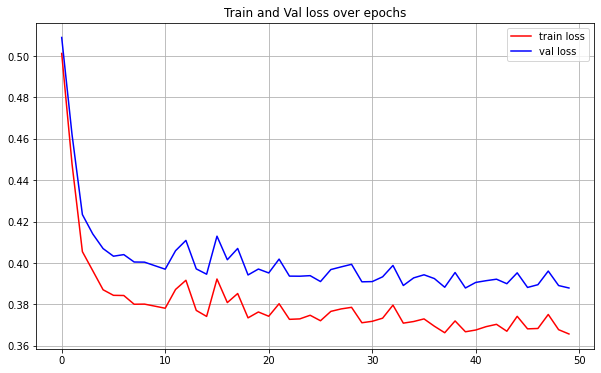

In [385]:
def main():
    # make dataset
    data = dt.make_classification(
                                    n_samples = 30000,
                                    n_features = 20,
                                    n_informative = 10,
                                    n_redundant= 6,
                                    n_repeated = 0,
                                    n_classes = 2,
                                    n_clusters_per_class = 3
                                )
    splitVals = (0.7, 0.2, 0.1)
    split_data = Utilities.train_test_val_split(splitVals, data)
    standardised_data = Utilities.normaliser(split_data)

    # make NN
    inputLayerSize=standardised_data[0][0].shape[1]
    layer2Size = 40
    outputLayerSize = 10
    batchSize=5
    LR=0.007
    numEpochs = 50
    neural_net = NN(input_layer_size=inputLayerSize,
                    layer2_size=layer2Size,
                    output_layer_size=outputLayerSize,
                    batch_size=batchSize,
                    lr=LR)

    # train NN for n epochs
    train_losses = []
    val_losses = []
    for epoch in range(numEpochs):

        # create random batches to use in epoch
        batch_indices_list = Utilities.batch_creator(batchSize, standardised_data[0])

        # iterate over batches
        for batch_indices in batch_indices_list:

            # get batch
            batch = (standardised_data[0][0][batch_indices, :], 
                    standardised_data[0][1][batch_indices]
                    )
            
            # forward propagation
            forward_mem = neural_net.forward_prop(batch)

            # backward propagation
            neural_net.backward_prop(forward_mem)
        
        # check losses after epoch
        val_loss = neural_net.forward_prop(standardised_data[2])['loss']
        train_loss = neural_net.forward_prop(standardised_data[0])['loss']
        val_losses.append(val_loss)
        train_losses.append(train_loss)
        print(f'Epoch {epoch} : * val loss {val_loss} * train loss {train_loss} *')

    # plot train and val loss
    plt.figure(figsize=(10, 6))
    plt.title('Train and Val loss over epochs')
    plt.plot(range(numEpochs), train_losses, c='r', label='train loss')
    plt.plot(range(numEpochs), val_losses, c='b', label='val loss')
    plt.grid()
    plt.legend()

    # check performance on test set
    y_bars_test = neural_net.forward_prop(standardised_data[1])['y_bars']
    rounded_y_bars_test = Utilities.round_preds(y_bars_test.shape[0], y_bars_test)
    ys_test = standardised_data[1][1]
    print('')
    print(f'Accuracy on test set {Utilities.accuracy(ys_test, rounded_y_bars_test)}')

# run script
if __name__ == '__main__':
    main()